Poisson's equation is <br/>
   $\Delta$ $\phi$ = f <br/>
where $\Delta$ is the laplace operator, and f and $\phi$ are real or complex valued functions on a manifold. Usually f is given and $\phi$ is sought. When the manifold is Euclidean space, the laplace is often denoted as $\nabla^2$ and so Poisson's equation is frequently written as <br/> $\nabla^2$$\phi$  = f. <br/>In two dimensional cartesian coordinates, it takes the form,<br/>
    $\frac{d^2\phi(x,y)}{dx^2} + \frac{d^2\phi(x,y)}{dy^2} = f(x,y)$ <br/> When f = 0, we obtain Laplace's equation.<br/>
To solve any equation, boundary conditions are needed. There are three type of boundary conditions(b.c.), Derichlet, where explicit values are prescribed on the boundary segment, Neumann, where derivative of sought function is prescribed a value, and third, a mixed b.c. of Derichlet and Neumann boundary conditions. <br/> The Poisson's equation is widely used in gravitational, electrostatics, fluid dynamics, traffic signal processing and many other fields.<br/><br/> There are several ways, this equation acan be solved. Exact solution can be obtained using Green's function and other methods. Very fast and accurate numerical solution can be obtained using finite difference, finite volume, finite element and other methods. The matrix inversion methods are effiecient for small dimensions, Jacobi and Gauss-Sidel iterative methods are good for any dimension and any bounday condition. The gradient decent and conjugate gradient methods are more efficient but are limited to zero derichlet bundary conditions on the edges. <br/><br/> On GitHub, we can find excellent work by many autors on these topics. One I like is Findiff library. This has the capability of solving any dimesion partial difference equation. There is no limitation on the size of the grid and boundary onditions. It gives accurate solution in matter of seconds.<br/><br/> Presently I will be aiming to solve the Poission's equation with Machine learning methods. There are several papers and works in this field. I will be pursuing the work of Lagaris et al on Artifical Neural Network for Solving Ordinary and Partial Differential Equations, arXiv:physics/9705023v1, May 1997[ref.1]. The work of Alexander Honchar(github.com/Rachnog)[ref. 2] and Tan(github/Tan) on Laplace equation is extended to Poission's equation. Alternate method is developed for more generic neural network with prescribed boundary conditions.


Artificial Neural networks method(ANN) for solving PDE is described in section 3.2 of ref 1. Section 4.2 has many problems and solutions.Problem 5 deals with the Derichlet b.c., problem 7 has mixed Derichlet and Neumann boundary conditions. These problems are contrived in the sense that the exact solution is known together with the source function f of Poission's equation. The comparison of ANN numerical solution and the exact solution is made to validate the numerical scheme. However in most research situations, the exact solution is never known in advance. If the research work develops ito a Poission's or any PDE, at most only the boundary conditions are known in advance. If the research goal is neural network or other ML methods, it will be wise to analyze the problem first with traditional methods such as finite difference, et al. The FinDiff library gives excellent capability to do so. Although ANN method works well for many PDEs, it runs into problem with problem 5 and 7 when used in ref.2 extension. Basically ANN nework gives pretty good initial condition for the problem, sometimes close to 90% of the final solution. After that, the gradient decent algorithms give excellent sloution in 100 to 200 iterations.<br/>The problem 5 in ref.1 has little problem. The initial condition, before any optimizations, show different behaviour than expected from the exact solution or from a numerical solution from FinDiff method. Proceeding with that intial condition, the solution converges to wrong solution. Let us examine what happens. The FinDiff solution is presented first.
.

In [2]:
import numpy as np
from findiff import FinDiff,  PDE, BoundaryConditions
from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from time import process_time

import autograd.numpy.random as npr
import autograd.numpy as np
import autograd
from  autograd import grad, elementwise_grad, jacobian
from autograd.misc.optimizers import adam

## Default parameters and plotting functions

shape = (21,21)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
dx, dy = x[1]-x[0], y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

nx = shape[0]
ny = shape[1]

x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1,  ny)

## For repeataability, use one seed only(like 31 below)
## The ANN computations were done with 11. You will see only minor 
## difference in solution

np.random.seed( 31 )

def plot2D(p, msg):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(X, Y, p, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
  legend = ax.legend(loc='best', shadow=True, fontsize='x-small', title=msg)
  legend.get_frame().set_facecolor('white')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$');
  plt.show()

def surfacePlot( Z, msg ):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  X, Y = np.meshgrid(x_space, y_space)
  surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
  legend = ax.legend(loc='best', shadow=True, fontsize='x-small', title=msg)
  legend.get_frame().set_facecolor('white')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$');
  plt.show()

    
def plotHeatmap( Z, title ):
	"""
	Plot a heatmap of a rectangular matrix.
	:param Z: An m-by-n matrix to plot.
	:param title: Figure title.
	:return:
	"""
	fig1 = plt.figure()
	im = plt.imshow( Z, cmap=cm.jet, extent=(0, 1, 0, 1), interpolation='bilinear' )
	fig1.colorbar( im )
	plt.title( title )
	plt.xlabel( r"$x_1$" )
	plt.ylabel( r"$x_2$" )
	plt.show()

def contourMaps(surf1, surf2, xx):

  fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))

# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#

  ax_2.contourf(X, Y, surf2, 20)
  ax_1.contourf(X, Y, surf1, 20)

# plot along the line y=0:
  jc = int(1/(2*dy))
  ax_3.plot(xx, surf1[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
  ax_3.plot(xx, surf2[:,jc], label=r'$pnew$')

# add some labels and titles
  ax_1.set_xlabel(r'$x$')
  ax_1.set_ylabel(r'$y$')
  ax_1.set_title('Exact solution')

  ax_2.set_xlabel(r'$x$')
  ax_2.set_ylabel(r'$y$')
  ax_2.set_title('Numerical solution')

  ax_3.set_xlabel(r'$x$')
  ax_3.set_ylabel(r'$p$')
  ax_3.set_title(r'$p(x,0)$')

  ax_3.legend();

  plt.show()




No handles with labels found to put in legend.


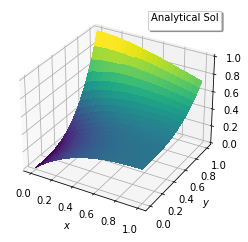

No handles with labels found to put in legend.


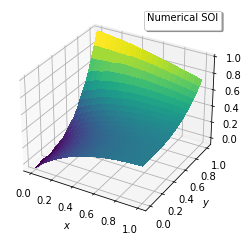

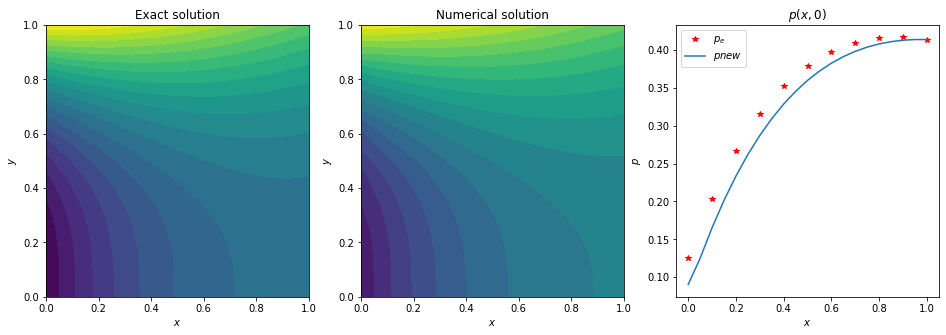

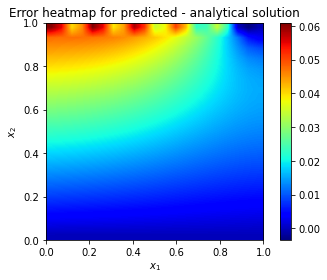

elapsed time in secs:  3.15625


In [2]:
##Ref: maroba/findiff on GitHUb

t2_start = process_time()

exact = np.exp(-X)*(X + Y **3)
f = np.exp(-X)*(X -2. + Y **3 + 6.*Y)

L = FinDiff(0, dx, 2) + FinDiff(1, dy, 2) 

bc = BoundaryConditions(shape)


bc[1,:] =  Y**3  # Dirichlet BC
bc[-1,:] = np.exp(-1.) *( 1. + Y**3) # Dirichlet BC
bc[:, 0] = FinDiff(1, dy, 1), 0  # Neumann BC
bc[1:-1, -1] = FinDiff(1, dy, 1), 3.* np.exp(-X)  # Neumann BC

u = np.zeros(shape)
pde = PDE(L, f, bc)
u = pde.solve()

plot2D(exact,"Analytical Sol")
plot2D(u, "Numerical SOl")

contourMaps(exact, u, x_space)
# Plotting the error heatmap.
plotHeatmap( exact-u, r"Error heatmap for predicted - analytical solution" )

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)


No handles with labels found to put in legend.


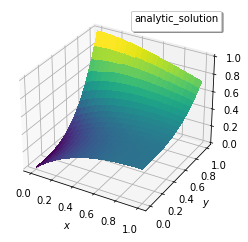

[1.04297262]
i  0 loss function  8.608142940810685
i  1 loss function  8.211678522962965
i  2 loss function  7.999660844320479
i  3 loss function  7.794011596405647
i  4 loss function  7.594119735661314
i  5 loss function  7.399806516189963
i  6 loss function  7.210900651779498
i  7 loss function  7.027237027626488
i  8 loss function  6.848656423291531
i  9 loss function  6.675005252371875
i  10 loss function  6.506135316292776
i  11 loss function  6.341903571357444
i  12 loss function  6.182171908227527
i  13 loss function  6.026806943061387
i  14 loss function  5.875679819590376
i  15 loss function  5.728666021462232
i  16 loss function  5.585645194226161
i  17 loss function  5.446500976376386
i  18 loss function  5.311120838909905
i  19 loss function  5.179395932890511
i  20 loss function  5.051220944544745
i  21 loss function  4.926493957446888
i  22 loss function  4.8051163213788275
i  23 loss function  4.686992527478035
i  24 loss function  4.572030089311667
i  25 loss function  

No handles with labels found to put in legend.


i  39 loss function  3.17212555548919


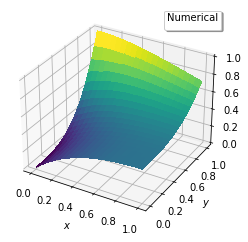

[0.001      0.0485127  0.09138858 0.1299669  0.16456488 0.195479
 0.22298628 0.24734552 0.26879834 0.2875703  0.30387186 0.31789935
 0.32983579 0.3398518  0.3481063  0.35474728 0.3599125  0.36373011
 0.36631926 0.36779071 0.36824732]
[0.001      0.04945409 0.09296979 0.13192399 0.16667543 0.19756394
 0.22490973 0.24901273 0.27015222 0.28858675 0.30455443 0.31827352
 0.32994342 0.33974578 0.34784586 0.35439397 0.3595269  0.36336937
 0.36603534 0.36762929 0.36824732]


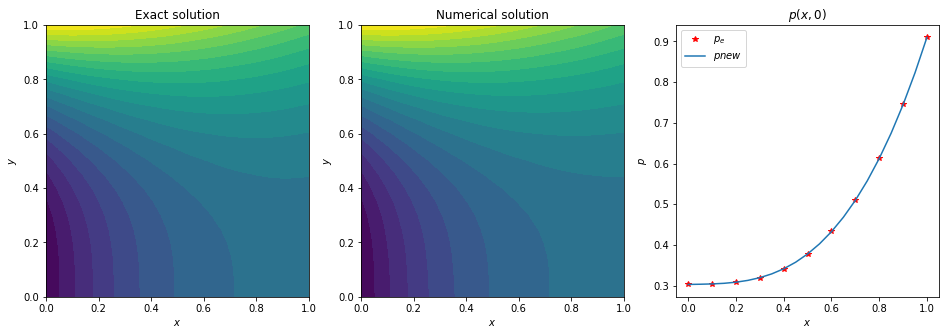

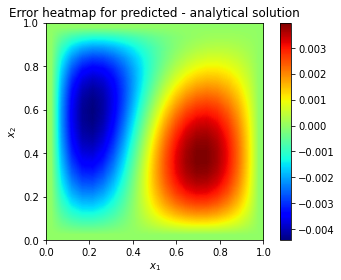

elapsed time in secs:  378.9375


In [3]:
## ANN prob 5,  Derichlet b.c.
## %matplotlib inline

t2_start = process_time()

X, Y = np.meshgrid(x_space, y_space)


def analytic_solution(X,Y):
    sol = np.exp(-X)*(X + Y **3)
    return sol

surface = np.zeros((nx, ny))
surface = analytic_solution(X,Y)

surfacePlot( surface, "analytic_solution" )       

def f(x):

   return np.exp(-x[0])*(x[0] -2. + x[1] **3 + 6.*x[1]) 

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x,W[0]))
    return np.dot(a1,W[1])


def neural_network_x(x):
    a1 = sigmoid(np.dot( x, W[0]))
    return np.dot( a1, W[1])

def A(x):
    return (1. - x[0])*x[1]**3 + x[0]*(1. + x[1]**3)*np.exp(-1.) \
            + (1. - x[1])*x[0]*(np.exp(-x[0]) - np.exp(-1.) ) \
            + x[1]*((1.+x[0])*np.exp(-x[0]) - (1. -x[0] + 2.*x[0]*np.exp(-1.)))  ## sign changed on last term

def psy_trial(x, net_out):
    return   A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out
   

def loss_function(W, x, y):
    loss_sum = 0.
    
    for yi in y:
        for xi in x:
            
            input_point = np.array([xi, yi])
            
            net_out = neural_network(W, input_point)[0]

            net_out_jacobian = jacobian(neural_network_x)(input_point)
            net_out_hessian = jacobian(jacobian(neural_network_x))(input_point)
            psy_t = psy_trial(input_point, net_out)
            psy_t_jacobian = jacobian(psy_trial)(input_point, net_out)
            psy_t_hessian = jacobian(jacobian(psy_trial))(input_point, net_out)

            gradient_of_trial_d2x = psy_t_hessian[0][0]
            gradient_of_trial_d2y = psy_t_hessian[1][1]

            func = f(input_point) # right part function

            err_sqr = ((gradient_of_trial_d2x + gradient_of_trial_d2y) - func)**2
            loss_sum += err_sqr
        
    return loss_sum


W = [npr.randn(2, 10), npr.randn(10, 1)]
lmb = 0.001

print (neural_network(W, np.array([1, 1])))

for i in range(40):
    loss_grad =  grad(loss_function)(W, x_space, y_space)

    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]

    print ('i ', i, 'loss function ', loss_function(W, x_space, y_space))

surface2 = np.zeros((nx, ny))
        
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network(W, [x, y])[0]  
     surface2[j][i] = psy_trial([x, y], net_outt)
    
surfacePlot( surface2, "Numerical" )
        

print( surface[2] )
print( surface2[2] )

contourMaps(surface, surface2, x_space)

# Plotting the error heatmap.
plotHeatmap( surface-surface2, r"Error heatmap for predicted - analytical solution" )

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)


The sign of last term in (1. -x[0] +##changed from - to + ## 2.*x[0]*np.exp(-1.)) in the boundary function A(x) warranted to get any reasonable solution. It took me almost a month to find this mistake, may be in ref. 1 theory or mine. It is highly suggested to check the starting solution before spending too much time in iterative solution. 

The problem 7 in ref. 1 has mixed bounday condition with one non-zero Neumann b.c. and the rest Derichlet b.c. are all zero. First we will get a FinDiff solution for a new problem and then ANN numerical method. The neural network in the trial solution has sign problem again. I have to change sign of last two terms in the trial solution to get going. 

No handles with labels found to put in legend.


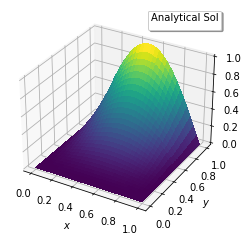

No handles with labels found to put in legend.


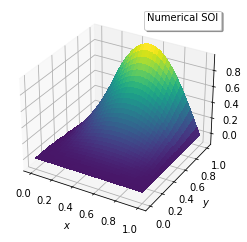

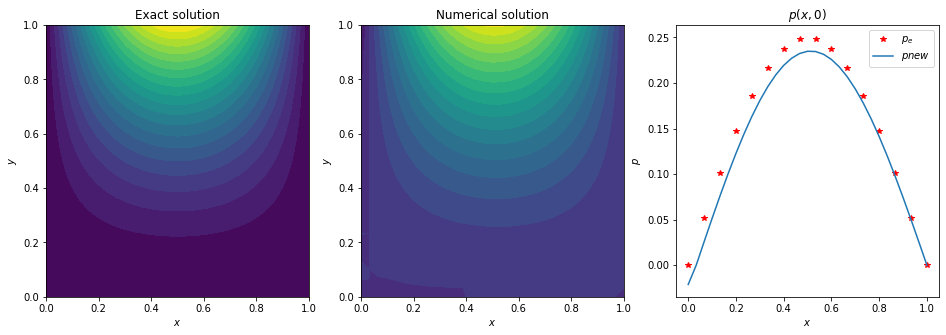

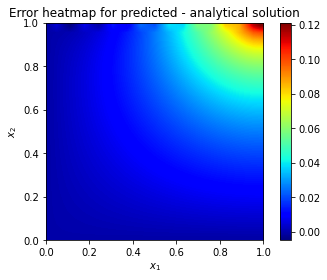

elapsed time in secs:  1.515625


In [5]:
## FinDiff Mixed b.c.
## Requires finer grid 21 or over

t2_start = process_time()

shape = (31,31)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
dx, dy = x[1]-x[0], y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

exact = (Y **2)* np.sin(np.pi*X)
f = (2. - (np.pi**2)*Y**2)*np.sin(np.pi*X)

L = FinDiff(0, dx, 2) + FinDiff(1, dy, 2) 

bc = BoundaryConditions(shape)


bc[1,:] =  0.  # Dirichlet BC
bc[-1,:] = 0. # Dirichlet BC
bc[:, 0] = 0.  # Derichlet BC
bc[1:-1, -1] = FinDiff(1, dy, 1), 2.*np.sin(np.pi*X) # Neumann BC


fnd_sol2 = np.zeros(shape)
pde = PDE(L, f, bc)
fnd_sol2 = pde.solve()

plot2D(exact,"Analytical Sol")
plot2D(fnd_sol2, "Numerical SOl")

contourMaps(exact, fnd_sol2, x)
# Plotting the error heatmap.
plotHeatmap( exact-fnd_sol2, r"Error heatmap for predicted - analytical solution" )

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)
## resetting default
shape = (10,10)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
dx, dy = x[1]-x[0], y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

The ANN solver is next.

No handles with labels found to put in legend.


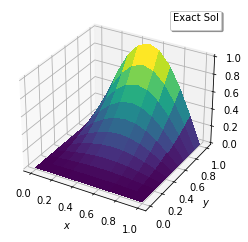

[-0.26881408]
i  0 loss function  66451.29448655748
i  1 loss function  6784.814169946263
i  2 loss function  5854.3867864373615
i  3 loss function  5741.429738556547
i  4 loss function  5665.391077145716
i  5 loss function  5606.246874841173
i  6 loss function  5556.690513228386
i  7 loss function  5513.174034709986
i  8 loss function  5473.610777929138
i  9 loss function  5436.5414578153595
i  10 loss function  5400.73054627991
i  11 loss function  5364.877723278741
i  12 loss function  5327.275541489742
i  13 loss function  5285.1952323785
i  14 loss function  5233.477611228411
i  15 loss function  5160.689770577243
i  16 loss function  5036.7006371305515
i  17 loss function  4764.943421719334
i  18 loss function  4005.817852050818
i  19 loss function  2629.0857975147164
i  20 loss function  2505.4432833421824
i  21 loss function  2448.2805057823216
i  22 loss function  2405.5284927487537
i  23 loss function  2368.8243224650487
i  24 loss function  2335.4211113758515
i  25 loss func

No handles with labels found to put in legend.


i  149 loss function  1486.37354862288


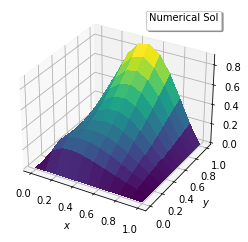

[0.00000000e+00 1.23606798e-02 2.35114101e-02 3.23606798e-02
 3.80422607e-02 4.00000000e-02 3.80422607e-02 3.23606798e-02
 2.35114101e-02 1.23606798e-02 4.89858720e-18]
[0.00000000e+00 1.86505971e-01 2.65053843e-01 2.84838212e-01
 2.72853335e-01 2.41956845e-01 1.98214700e-01 1.45902028e-01
 9.02512169e-02 3.85275596e-02 4.89858720e-17]


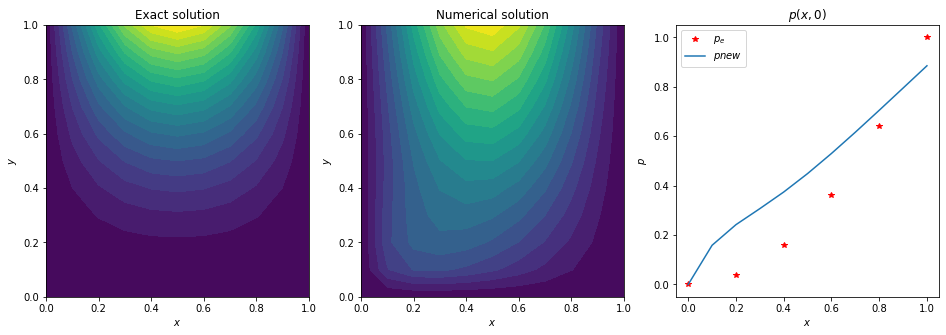

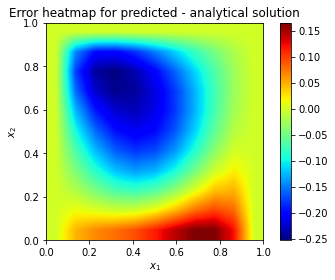

elapsed time in secs:  182.859375


In [12]:
## ANN Prob 7 Mixed b.c.

t2_start = process_time()

X, Y = np.meshgrid(x_space, y_space)

def analytic_solution(X,Y):
    sol = ( Y **2) * np.sin(np.pi*X)
    return sol

surface = np.zeros((nx, ny))
surface = analytic_solution(X,Y)

plot2D(surface, "Exact Sol")


def f(x):

   return (2.- (np.pi**2)* x[1]**2  )* np.sin(np.pi*x[0])

def sigmoid(x):
    return 1. / (1. + np.exp(-x))



def neural_network(W, x):
    a1 = sigmoid(np.dot(x,W[0]))
    return np.dot(a1,W[1])


def neural_network_x(x):
    a1 = sigmoid(np.dot( x, W[0]))
    return np.dot( a1, W[1])

def B(x):

    return 2.*x[1]*np.sin(np.pi*x[0])


def psy_trial(x, net_out, net_out1, net_out_dy):

    return   B(x) +  x[0] * (1 - x[0]) * x[1] * (net_out + net_out1 + net_out_dy )

def loss_function(W, x, y):
    loss_sum = 0.
    
    for yi in y:
        for xi in x:
            
            
            input_point = np.array([xi,yi])
            net_out = neural_network(W, input_point)[0]
            input_bc1 = np.array([xi,1])
            net_out1 = neural_network(W, input_bc1)[0]
            input_bc2 = np.array([xi,1-dy])
            net_out2 = neural_network(W, input_bc2)[0]
            net_out_dy = (net_out1 - net_out2)/dy 
            net_out_jacobian = jacobian(neural_network_x)(input_point)
            net_out_hessian = jacobian(jacobian(neural_network_x))(input_point)
            psy_t = psy_trial(input_point, net_out, net_out1, net_out_dy)
            psy_t_jacobian = jacobian(psy_trial)(input_point, net_out, net_out1, net_out_dy)
            psy_t_hessian = jacobian(jacobian(psy_trial))(input_point, net_out, net_out1, net_out_dy)

            gradient_of_trial_d2x = psy_t_hessian[0][0]
            gradient_of_trial_d2y = psy_t_hessian[1][1]

            func = f(input_point) # right part function

            err_sqr = ((gradient_of_trial_d2x + gradient_of_trial_d2y ) \
                       - func)**2
            loss_sum += err_sqr
        
    return loss_sum


W = [npr.randn(2, 12), npr.randn(12, 1)]
lmb = 0.001

print (neural_network(W, np.array([1, 1])))

for i in range(150):
    loss_grad =  grad(loss_function)(W, x_space, y_space)

    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]

    print ('i ', i, 'loss function ', loss_function(W, x_space, y_space))

surface2 = np.zeros((nx, ny))
        
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network(W, [x, y])[0]
     input_bc1 = np.array([x,1])
     net_out1 = neural_network(W, input_bc1)[0]
     input_bc2 = np.array([x,1-dy])
     net_out2 = neural_network(W, input_bc2)[0]
     net_out_dy = (net_out1 - net_out2)/dy 
     surface2[j][i] = psy_trial([x, y], net_outt, net_out1, net_out_dy)

plot2D(surface2, "Numerical Sol")
        

print( surface[2] )
print( surface2[2] )

contourMaps(surface,surface2,x_space)


# Plotting the error heatmap.
plotHeatmap( surface-surface2, r"Error heatmap for predicted - analytical solution" )

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)


No handles with labels found to put in legend.


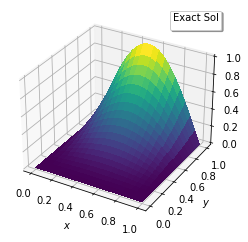

No handles with labels found to put in legend.


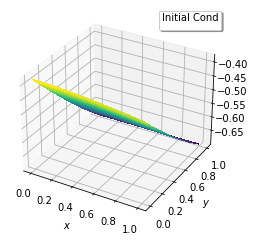

Iteration   0 objective 3985.4261293738055
Iteration  10 objective 2138.5058816275778
Iteration  20 objective 1194.6219453109586
Iteration  30 objective 1005.6150678844036
Iteration  40 objective 961.1820248422622
Iteration  50 objective 741.8740154091612
Iteration  60 objective 638.5133031601874
Iteration  70 objective 464.2026846014027
Iteration  80 objective 345.43847773086594
Iteration  90 objective 301.01005570385723
Iteration 100 objective 244.06309396598348
Iteration 110 objective 204.94617762314988
Iteration 120 objective 181.16262895422753
Iteration 130 objective 167.0177078759513
Iteration 140 objective 257.39760323240694
Iteration 150 objective 156.81455285859266
Iteration 160 objective 141.70083689615691
Iteration 170 objective 131.01512071222453
Iteration 180 objective 128.2985289155198
Iteration 190 objective 119.92017305102003
Iteration 200 objective 135.2165810868942
Iteration 210 objective 126.55461184171517
Iteration 220 objective 109.72778339824404
Iteration 230 obje

No handles with labels found to put in legend.


Iteration 500 objective 35.111023814479765


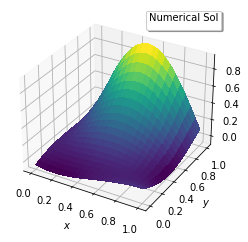

[0.00000000e+00 1.56434465e-03 3.09016994e-03 4.53990500e-03
 5.87785252e-03 7.07106781e-03 8.09016994e-03 8.91006524e-03
 9.51056516e-03 9.87688341e-03 1.00000000e-02 9.87688341e-03
 9.51056516e-03 8.91006524e-03 8.09016994e-03 7.07106781e-03
 5.87785252e-03 4.53990500e-03 3.09016994e-03 1.56434465e-03
 1.22464680e-18]
[-0.01663421 -0.02620156 -0.03336398 -0.03777851 -0.03937238 -0.03830962
 -0.03493974 -0.0297352  -0.02322644 -0.01594336 -0.00837091 -0.00092341
  0.00606104  0.0123081   0.01758105  0.02164644  0.02423794  0.02502393
  0.02358437  0.01940203  0.01187248]


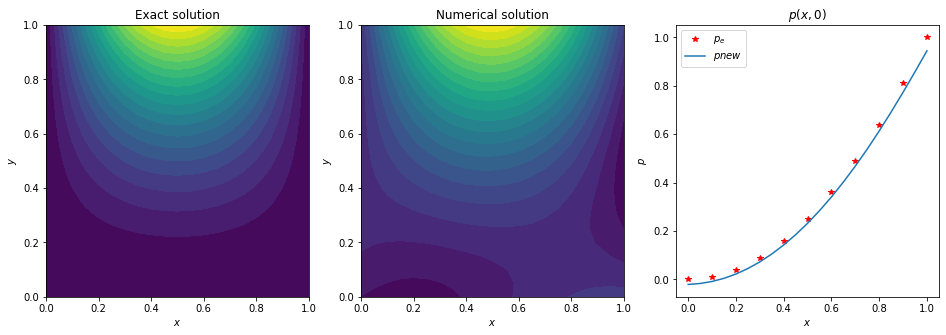

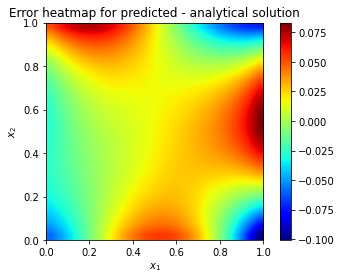

elapsed time in secs:  1564.53125


In [3]:
## Prob 7 with mixed b.c.
## %matplotlib inline

t2_start = process_time()

X, Y = np.meshgrid(x_space, y_space)

pi = np.pi

def analytic_solution(X,Y):
    sol = ( Y **2) * np.sin(np.pi*X)
    return sol

surface = np.zeros((nx, ny))
surface = analytic_solution(X,Y)

  
plot2D(surface, "Exact Sol")


def f(x):

   return (2.- (np.pi**2)* x[1]**2  )* np.sin(np.pi*x[0])


def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def sigmoidPrime( z ):
	"""
	Derivative of sigmoid function.
	:param z: Input vector of values.
	:return: Element-wise sigmoid'(z).
	"""
	return sigmoid( z ) * ( 1.0 - sigmoid( z ) )


def sigmoidPrimePrime( z ):
	"""
	Second derivative of sigmoid function.
	:param z: Input vector of values.
	:return: Element-wise sigmoid''(z).
	"""
	return sigmoid( z ) * ( 1.0 - sigmoid( z ) ) * ( 1.0 - 2.0 * sigmoid( z ) )


def neural_network(x, W):
    Wt = W[0][0]                    
    b = W[0][1]
    V = W[1][0]                 
    z = np.dot( Wt, x ) + b
    sigma = sigmoid( z )                
    return np.dot( V, sigma )


def dkNnet_dxjk( x, W, j, k ):
	"""
	Compute the kth partial derivate of the nnet with respect to the jth input value.
	:param x: Input vector with two coordinates: (x_1, x_2).
	:param params: Network parameters (cfr. nnet(.)).
	:param j: Input coordinate with respect to which we need the partial derivative (0: x_1, 1: x_2).
	:param k: Partial derivative order (1 or 2 supported).
	:return: \frac{d^kN}{dx_j^k} evaluated at x = (x_1, x_2).
	"""
	Wt = W[0][0]
	b = W[0][1]
	V = W[1][0]
	z = np.dot(Wt, x)+b
	if k == 1:
		sigmaPrime = sigmoidPrime( z )
	else:
		sigmaPrime = sigmoidPrimePrime( z )
	return np.dot( V * (Wt[:,j] ** k), sigmaPrime )


def loss_function(W, step):
    loss_sum = 0.
    
    for yi in y_space:
        for xi in x_space:
                        
            input_point = np.array([xi,yi])
                        
            func = f(input_point)
            
            bc1 =  neural_network( np.array([xi,0]), W) - np.zeros(nx)
##            bc2 =  neural_network(np.array([xi,1]), W)  - np.sin(np.pi*xi)  ##derichlet bc
            bc2 =  dkNnet_dxjk( np.array([xi,1]), W, 1, 1 )  - 2.*np.sin(np.pi*xi)
            bc3 = neural_network( np.array([0,yi]), W) - np.zeros(ny) 
            bc4 = neural_network( np.array([1.,yi]), W) - np.zeros(ny)
            err_sqr = ((dkNnet_dxjk( input_point, W, 0, 2 ) + dkNnet_dxjk( input_point, W, 1, 2 ) ) \
                       - func)
            err_sqr = np.mean(err_sqr**2 + (bc1**2 + bc2**2 + bc3**2 + bc4**2))
            loss_sum += err_sqr
        
    return loss_sum

np.random.seed( 11 )
H = 7
W = [(np.random.uniform( -1, +1, (H,2) ), np.random.uniform( -1, +1, H )), \
     (np.random.uniform( -1, +1, H ),)]


## For a restart, load W
##W =  pickle.load(open('W_rest_neum', 'rb'))

surface2 = np.zeros((nx, ny))
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network([x, y], W)
     surface2[j][i] = net_outt


plot2D(surface2, "Initial Cond")


def callback(W, step, g):
    if step % 10 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                     loss_function(W, step)))
W =  adam(grad(loss_function), W, step_size = 0.3, 
                num_iters=501, callback=callback)
        
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network( [x, y], W)
     surface2[j][i] = net_outt

plot2D(surface2, "Numerical Sol")
        


print( surface[2] )
print( surface2[2] )

contourMaps(surface, surface2,x_space)
# Plotting the error heatmap.
plotHeatmap( surface-surface2, r"Error heatmap for predicted - analytical solution" )

## For a restart, save W     
##pickle.dump(W, open('W_rest_neum', 'wb'), protocol=4)

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)


No handles with labels found to put in legend.


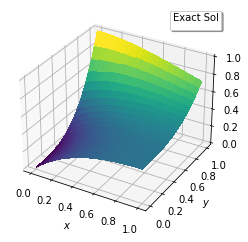

No handles with labels found to put in legend.


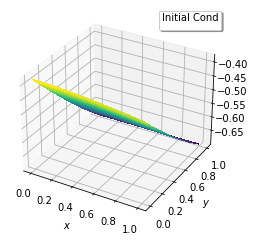

Iteration   0 objective 3421.278292864114
Iteration  10 objective 1598.7382149395291
Iteration  20 objective 1264.070039461291
Iteration  30 objective 628.2590429290539
Iteration  40 objective 148.87085172369243
Iteration  50 objective 58.68002999320845
Iteration  60 objective 22.270614804448716
Iteration  70 objective 18.192562083715725
Iteration  80 objective 13.457020515277373
Iteration  90 objective 11.298875411945373
Iteration 100 objective 10.51502825969199
Iteration 110 objective 9.644806536289625
Iteration 120 objective 9.033396077098397
Iteration 130 objective 8.470178485070992
Iteration 140 objective 7.991869695389667
Iteration 150 objective 7.6067942994660465
Iteration 160 objective 7.297014953170534
Iteration 170 objective 7.039817627814535
Iteration 180 objective 6.816691066359681
Iteration 190 objective 6.913744061441208
Iteration 200 objective 11.751990156017149
Iteration 210 objective 7.13778448198374
Iteration 220 objective 6.3337800383066245
Iteration 230 objective 6.

No handles with labels found to put in legend.


Iteration 500 objective 1.6449073495479631


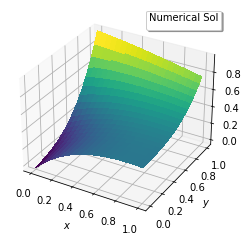

[0.001      0.0485127  0.09138858 0.1299669  0.16456488 0.195479
 0.22298628 0.24734552 0.26879834 0.2875703  0.30387186 0.31789935
 0.32983579 0.3398518  0.3481063  0.35474728 0.3599125  0.36373011
 0.36631926 0.36779071 0.36824732]
[-0.01803015  0.03434827  0.08157237  0.12394832  0.16178937  0.19540597
  0.22509848  0.25115219  0.27383434  0.29339294  0.31005685  0.32403689
  0.3355276   0.34470935  0.35175061  0.35681014  0.36003897  0.36158216
  0.36158013  0.36016973  0.35748485]


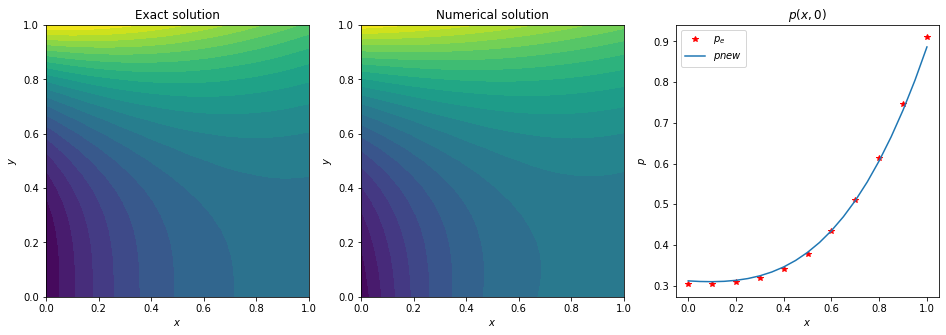

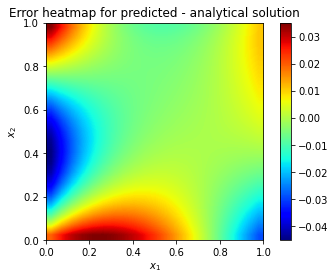

elapsed time in secs:  1561.328125


In [4]:
## Prob 5 with Deichlet bc

t2_start = process_time()
X, Y = np.meshgrid(x_space, y_space)
pi = np.pi


def analytic_solution(X,Y):
    sol = np.exp(-X)*(X+Y**3)
    return sol

surface = np.zeros((nx, ny))
surface = analytic_solution(X,Y)


    
plot2D(surface, "Exact Sol")


def f(x):

   return np.exp(-x[0])*(x[0] - 2. + x[1]**3 + 6.*x[1])


def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def sigmoidPrime( z ):
	"""
	Derivative of sigmoid function.
	:param z: Input vector of values.
	:return: Element-wise sigmoid'(z).
	"""
	return sigmoid( z ) * ( 1.0 - sigmoid( z ) )


def sigmoidPrimePrime( z ):
	"""
	Second derivative of sigmoid function.
	:param z: Input vector of values.
	:return: Element-wise sigmoid''(z).
	"""
	return sigmoid( z ) * ( 1.0 - sigmoid( z ) ) * ( 1.0 - 2.0 * sigmoid( z ) )


def neural_network(x, W):
    Wt = W[0][0]                    
    b = W[0][1]
    V = W[1][0]                 
    z = np.dot( Wt, x ) + b
    sigma = sigmoid( z )                
    return np.dot( V, sigma )


def dkNnet_dxjk( x, W, j, k ):
	"""
	Compute the kth partial derivate of the nnet with respect to the jth input value.
	:param x: Input vector with two coordinates: (x_1, x_2).
	:param params: Network parameters (cfr. nnet(.)).
	:param j: Input coordinate with respect to which we need the partial derivative (0: x_1, 1: x_2).
	:param k: Partial derivative order (1 or 2 supported).
	:return: \frac{d^kN}{dx_j^k} evaluated at x = (x_1, x_2).
	"""
	Wt = W[0][0]
	b = W[0][1]
	V = W[1][0]
	z = np.dot(Wt, x)+b
	if k == 1:
		sigmaPrime = sigmoidPrime( z )
	else:
		sigmaPrime = sigmoidPrimePrime( z )
	return np.dot( V * (Wt[:,j] ** k), sigmaPrime )


def loss_function(W, step):
    loss_sum = 0.
    
    for yi in y_space:
        for xi in x_space:
                        
            input_point = np.array([xi,yi])
                        
            func = f(input_point)
            
            bc1 =  neural_network( np.array([xi,0]), W) - np.exp(-xi)*(xi)
            bc2 =  neural_network(np.array([xi,1]), W)  - np.exp(-xi)*(xi+1.) 
            bc3 = neural_network( np.array([0,yi]), W) - (yi**3) 
            bc4 = neural_network( np.array([1.,yi]), W) - np.exp(-1.)*(1.+yi**3)
            err_sqr = ((dkNnet_dxjk( input_point, W, 0, 2 ) + dkNnet_dxjk( input_point, W, 1, 2 ) ) \
                       - func)
            err_sqr = np.mean(err_sqr**2 + (bc1**2 + bc2**2 + bc3**2 + bc4**2))
            loss_sum += err_sqr
        
    return loss_sum

np.random.seed( 11 )
H = 7
W = [(np.random.uniform( -1, +1, (H,2) ), np.random.uniform( -1, +1, H )), \
     (np.random.uniform( -1, +1, H ),)]


## For a restart, load W
##W =  pickle.load(open('W_rest_neum', 'rb'))

surface2 = np.zeros((nx, ny))
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network([x, y], W)
     surface2[j][i] = net_outt


plot2D(surface2, "Initial Cond")


def callback(W, step, g):
    if step % 10 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                     loss_function(W, step)))
W =  adam(grad(loss_function), W, step_size = 0.3, 
                num_iters=501, callback=callback)
        
for i, x in enumerate(x_space):
  for j, y in enumerate(y_space):
     net_outt = neural_network( [x, y], W)
     surface2[j][i] = net_outt

plot2D(surface2, "Numerical Sol")
        


print( surface[2] )
print( surface2[2] )

contourMaps(surface, surface2,x_space)
# Plotting the error heatmap.
plotHeatmap( surface-surface2, r"Error heatmap for predicted - analytical solution" )

## For a restart, save W     
##pickle.dump(W, open('W_rest_neum', 'wb'), protocol=4)

t2_stop = process_time()
print("elapsed time in secs: ", t2_stop-t2_start)


Various state of the art Machine learning Poission's equation solvers were reviewed. The solution with prescribed boundary condions does good job, however more iterations are required. I think this method is preferable as the boundary condition can be explicitly prescribed. Several published papers cite superior usage of BFGS method over Adam optimization. The scipy.minimize has various minimization options. You are encouraged to try these options and enhance these methods.